### Testing Evo

#### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch_geometric
from torch_geometric.nn import GCNConv
import IPython
from IPython.display import display, HTML

from graphUtils import add_edges
from generator import generate_organism
from cell import Cell
from organism import Organism
from GNCAmodel import GNCA
from visualizer import Visualizer
from evo_trainer import Evo_Trainer

2023-02-07 13:36:49,943	INFO worker.py:1528 -- Started a local Ray instance.


#### Train the network

In [2]:
n = 10
popsize = 20
generations = 100
name = 'centered3'
#device = torch.device('mps:0')
device = torch.device('cpu')
trainer = Evo_Trainer(n, device, popsize=popsize)

[2023-02-07 13:36:51] INFO     <45616> evotorch.core: Instance of `Custom_NEProblem` (id:4443191904) -- The `dtype` for the problem's decision variables is set as torch.float32
[2023-02-07 13:36:51] INFO     <45616> evotorch.core: Instance of `Custom_NEProblem` (id:4443191904) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2023-02-07 13:36:51] INFO     <45616> evotorch.core: Instance of `Custom_NEProblem` (id:4443191904) -- The `device` of the problem is set as cpu
[2023-02-07 13:36:51] INFO     <45616> evotorch.core: Instance of `Custom_NEProblem` (id:4443191904) -- The number of actors that will be allocated for parallelized evaluation is 10
[2023-02-07 13:36:51] INFO     <45616> evotorch.core: Instance of `Custom_NEProblem` (id:4443191904) -- Number of GPUs that will be allocated per actor is None


/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/tools/misc.py:1107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(data, **kwargs)


In [ ]:
trainer.train(generations, name)

RayTaskError(RuntimeError): [36mray::EvaluationActor.evaluate_batch_piece()[39m (pid=45644, ip=127.0.0.1, repr=<evotorch.core.EvaluationActor object at 0x128b7e440>)
  File "/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/core.py", line 169, in evaluate_batch_piece
    return piece_index, self.evaluate_batch(batch_piece)
  File "/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/core.py", line 153, in evaluate_batch
    self._problem.evaluate(solution_batch)
  File "/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/core.py", line 2395, in evaluate
    self._evaluate_all(batch)
  File "/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/core.py", line 2413, in _evaluate_all
    self._evaluate_batch(batch)
  File "/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/core.py", line 2447, in _evaluate_batch
    self._evaluate(sln)
  File "/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/neuroevolution/neproblem.py", line 424, in _evaluate
    fitnesses = evaluator(self.parameterize_net(parameters))
  File "/Users/martinholst/Desktop/MultiCellularAutomata/Thesis/src/evo_trainer.py", line 43, in _evaluate_network
    graph, velocity_bonus, border_cost, food_reward, dead_cost = network(graph, steps)
  File "/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/Users/martinholst/Desktop/MultiCellularAutomata/Thesis/src/GNCAmodel.py", line 145, in forward
    graph, velocity, border_cost, food_reward, dead_cost, viable = self.update(graph)
  File "/Users/martinholst/Desktop/MultiCellularAutomata/Thesis/src/GNCAmodel.py", line 122, in update
    velocity = self.update_graph(graph)
  File "/Users/martinholst/Desktop/MultiCellularAutomata/Thesis/src/GNCAmodel.py", line 98, in update_graph
    acceleration = acceleration * torch.stack((food_mask, food_mask), dim=1)
RuntimeError: The size of tensor a (30) must match the size of tensor b (2) at non-singleton dimension 1

2023-02-07 13:37:00,707	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::EvaluationActor.evaluate_batch_piece() (pid=45648, ip=127.0.0.1, repr=<evotorch.core.EvaluationActor object at 0x12fc963e0>)
  File "/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/core.py", line 169, in evaluate_batch_piece
    return piece_index, self.evaluate_batch(batch_piece)
  File "/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/core.py", line 153, in evaluate_batch
    self._problem.evaluate(solution_batch)
  File "/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/core.py", line 2395, in evaluate
    self._evaluate_all(batch)
  File "/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/core.py", line 2413, in _evaluate_all
    self._evaluate_batch(batch)
  File "/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/core.py", line 244

In [ ]:
network = trainer.get_trained_network()

In [ ]:
#network = trainer.problem.parameterize_net(trainer.searcher.status['best'])

#### Visualize trained network

In [ ]:
organism = generate_organism(n, device)
graph = organism.toGraph()
visualizer = Visualizer()

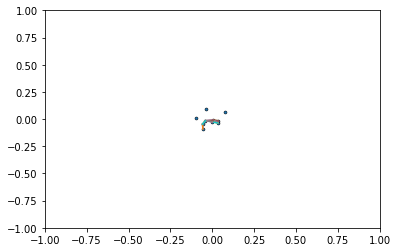

In [ ]:
anim = visualizer.animate_organism(graph, network, frames=100)
IPython.display.HTML(anim.to_jshtml())

In [ ]:
#anim.save('../animation/centered2.gif', writer='imagemagick', fps=10)
visualizer.save_animation_to_gif(anim, name, 10)

In [ ]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>